In [1]:
import torch
from torch.utils.data import DataLoader

from dataset.en_vi_dataset import EN_VIDataset
from models.model import Transformer
from utils.utils import input_target_collate_fn

import matplotlib.pyplot as plt
import traceback

In [2]:
src_path = 'data/en-vi/raw-data/test/tst2013.en'
trg_path = 'data/en-vi/raw-data/test/tst2013.vi'

# pretrained_path = 'checkpoints/Transformer-En2Vi-TPE-2021_07_21-04_03_16/best_bleu-bleu=0.151.pth'
pretrained_path = 'checkpoints/Transformer-En2Vi-TPE-2021_07_21-12_07_19/best_bleu-bleu=0.0754.pth'

dev = 'cpu'

In [3]:
ds = EN_VIDataset(
    src_path=src_path,
    trg_path=trg_path,
    # src_vocab=["vocab/shared/shared-vocab.json",
    #            "vocab/shared/shared-merges.txt"],
    # trg_vocab=["vocab/shared/shared-vocab.json",
    #            "vocab/shared/shared-merges.txt"]
)
dl = DataLoader(ds, batch_size=4, collate_fn=input_target_collate_fn)

In [4]:
TRG_EOS_TOKEN = '</s>'
TRG_EOS_ID = ds.vi_tokenizer.token_to_id(TRG_EOS_TOKEN)

In [5]:
config = torch.load(pretrained_path, map_location=dev)

In [6]:
model = Transformer(
    n_src_vocab=ds.en_tokenizer.get_vocab_size(),
    n_trg_vocab=ds.vi_tokenizer.get_vocab_size(),
    src_pad_idx=ds.en_tokenizer.token_to_id('<pad>'),
    trg_pad_idx=ds.vi_tokenizer.token_to_id('<pad>'),
    **config['config']['model']
).to(dev)
model.load_state_dict(config['model_state_dict'])
model.eval()
print()

# **Visualize attention**

In [7]:
def visualize_attn(attn, dsts, ques):
    for j, (b, dst, que) in enumerate(zip(attn, dsts, ques)):
        print(f'===== Input {j} =====')
        fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
        ax.imshow(b.mean(0).detach().cpu())
        
        ax.set_xticks(range(len(dst)))
        ax.set_xticklabels(dst)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        ax.set_yticks(range(len(que)))
        ax.set_yticklabels(que)
        plt.show()

In [8]:
@torch.no_grad()
def make_prediction(i, src, trg):
    src = src.to(dev)
    trg = trg.to(dev)

    src_ = src.cpu().numpy()
    src_tokens = [[ds.en_tokenizer.id_to_token(ss) for ss in s] for s in src_]
    src_ = ds.en_tokenizer.decode_batch(src_)
    # print('Source', src_tokens)

    trg_ = trg.cpu().numpy()
    trg_tokens = [[ds.vi_tokenizer.id_to_token(ss) for ss in s] for s in trg_]
    # trg_ = ds.vi_tokenizer.decode_batch(trg_)
    # print('Target', trg_tokens)

    pred = model(src, trg[:, :-1])
    pred_ = pred.argmax(-1).cpu().numpy()
    pred_tokens = [[ds.vi_tokenizer.id_to_token(ss) for ss in s] for s in pred_]
    # pred_ = ds.vi_tokenizer.decode_batch(pred_)
    # print('Prediction', pred_tokens)

    return src_tokens, trg_tokens, pred_tokens

In [9]:
def hook(m, i, o):
    global attn
    try:
        attn = o[1]
    except:
        traceback.print_exc()
        handle.remove()
    handle.remove()

## **Encoder self-attention**

===== Input 0 =====


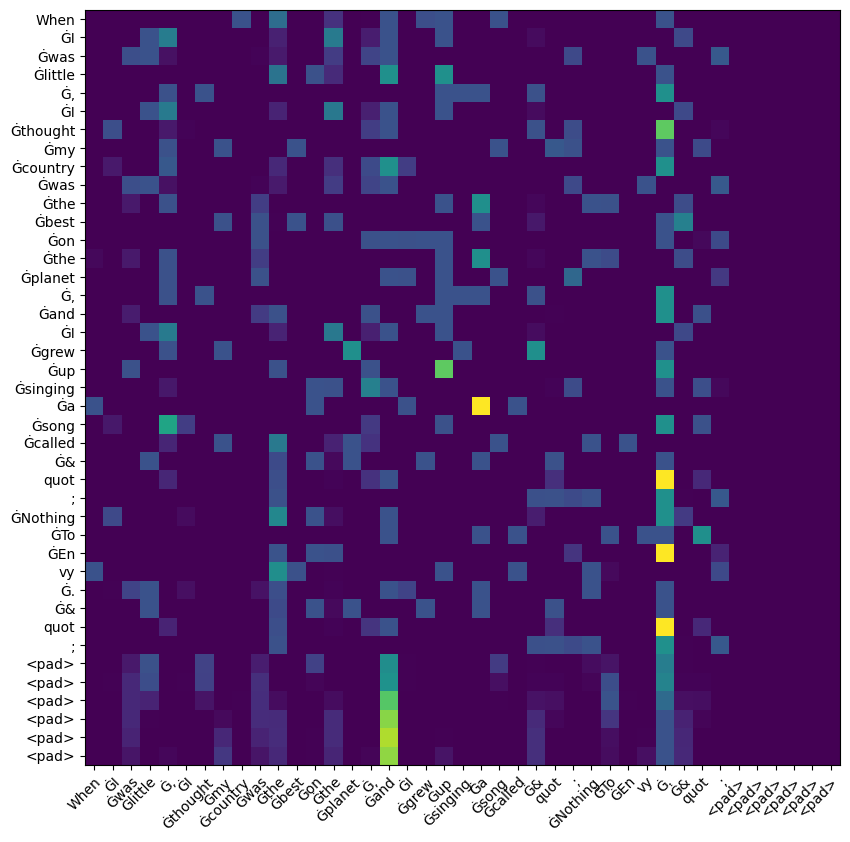

===== Input 1 =====


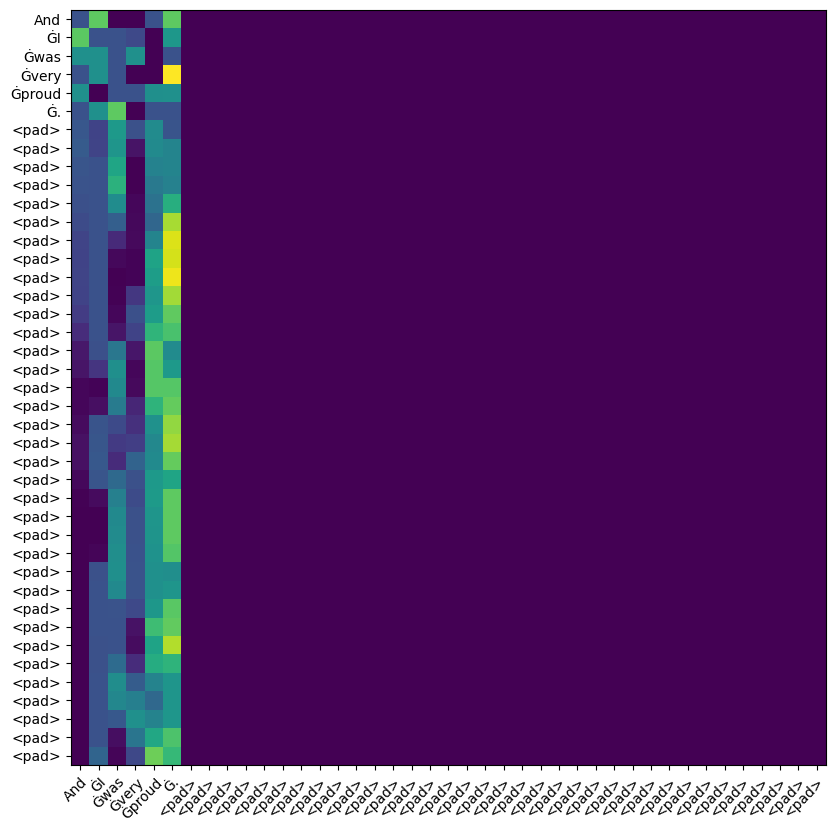

===== Input 2 =====


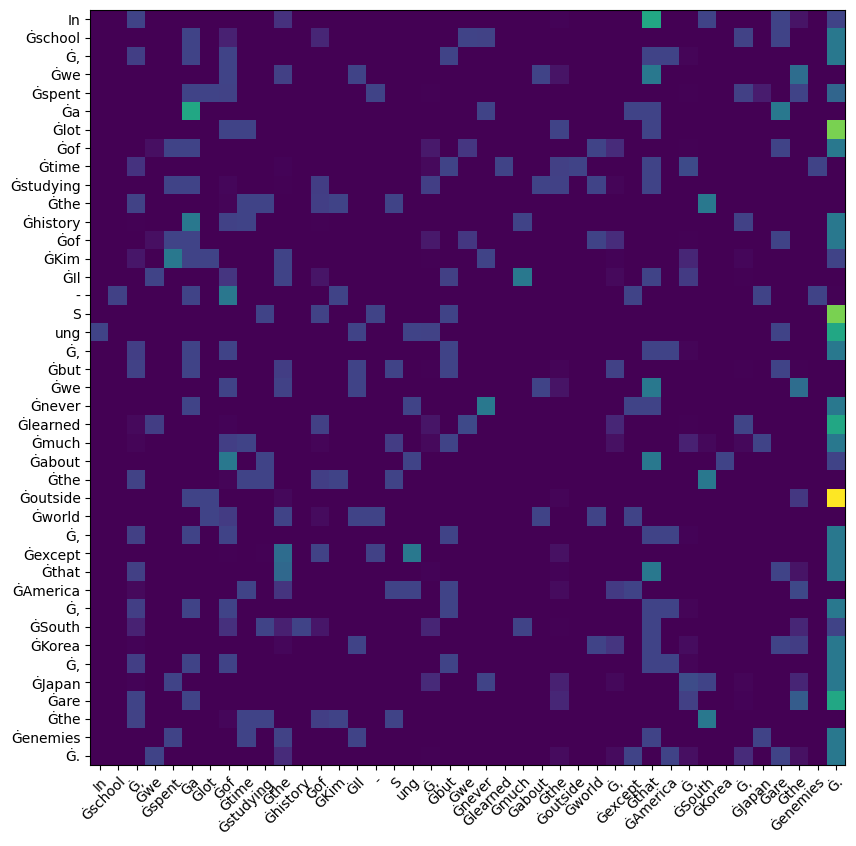

===== Input 3 =====


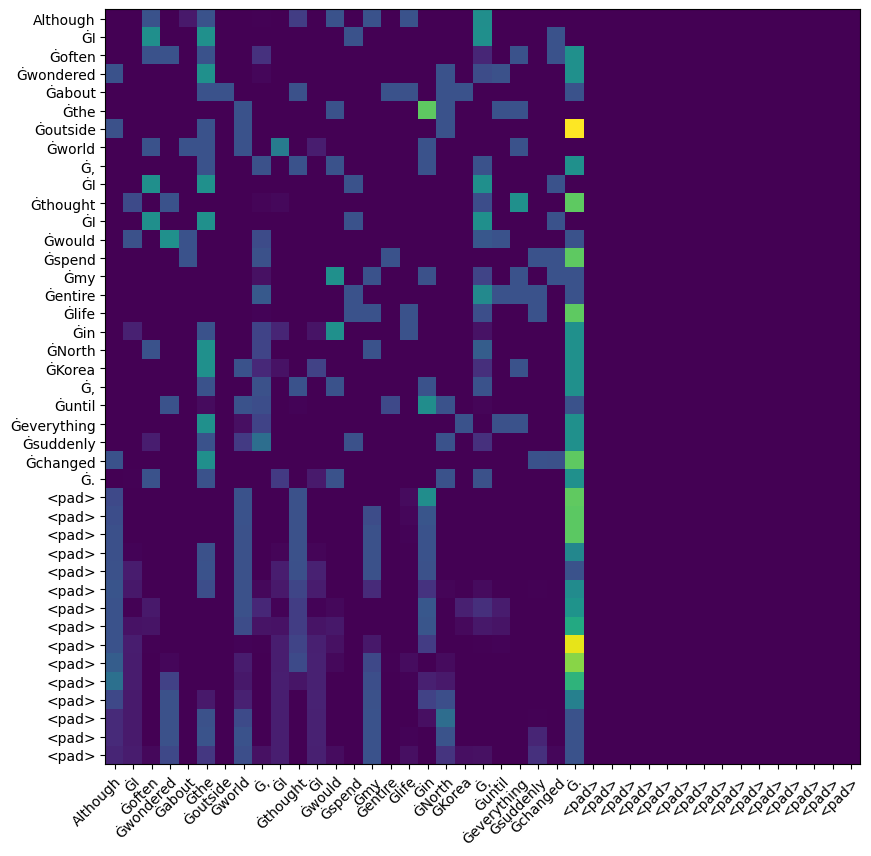

In [10]:
handle = model.encoder.layer_stack[0].self_attn.attention.register_forward_hook(hook)

for i, (src, trg) in enumerate(dl):
    attn = None
    src_tokens, trg_tokens, pred_tokens = make_prediction(i, src, trg)
    visualize_attn(attn, src_tokens, src_tokens)
    break

## **Decoder self-attention**

===== Input 0 =====


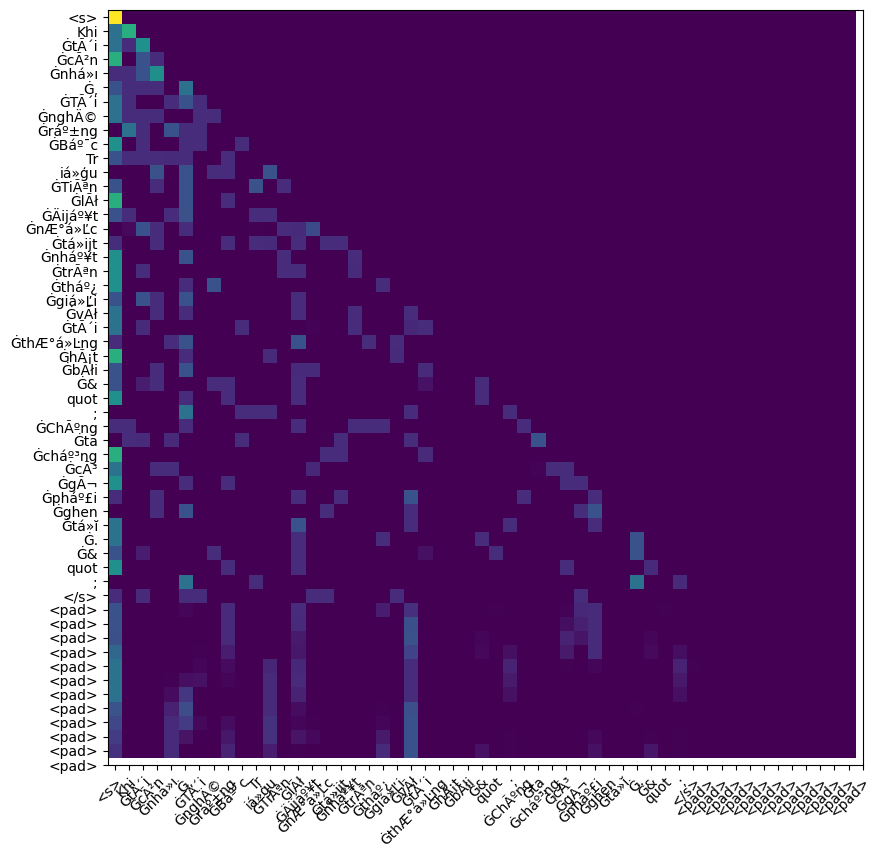

===== Input 1 =====


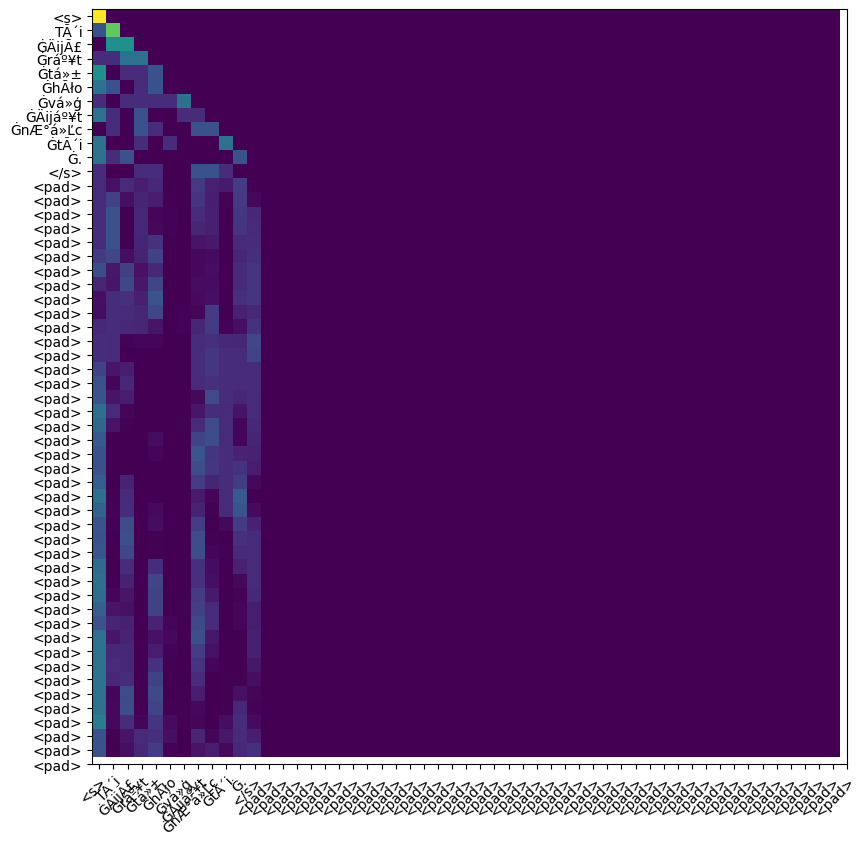

===== Input 2 =====


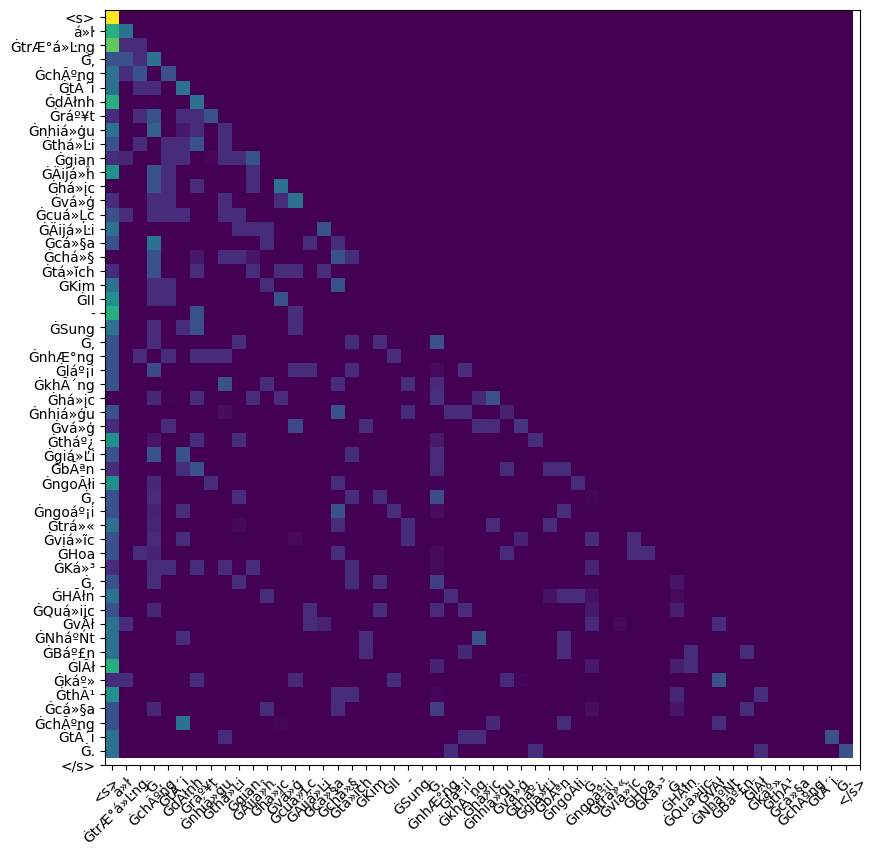

===== Input 3 =====


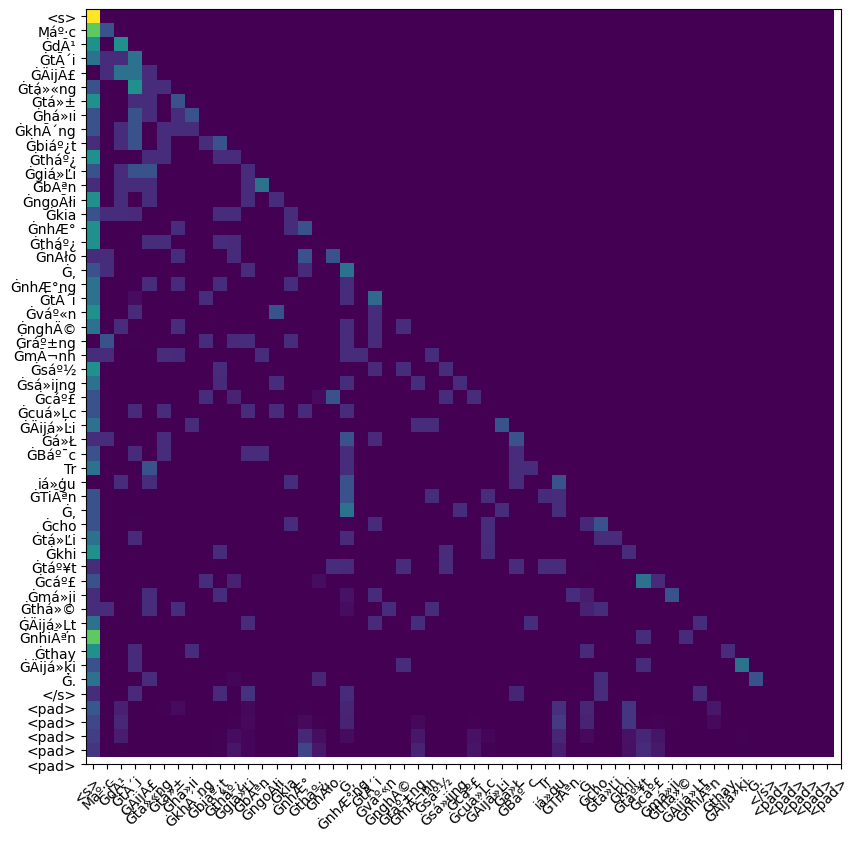

In [11]:
handle = model.decoder.layer_stack[0].masked_self_attn.attention.register_forward_hook(hook)

for i, (src, trg) in enumerate(dl):
    src_tokens, trg_tokens, pred_tokens = make_prediction(i, src, trg)
    visualize_attn(attn, trg_tokens, trg_tokens)
    break

## **Encoder-Decoder attention**

===== Input 0 =====


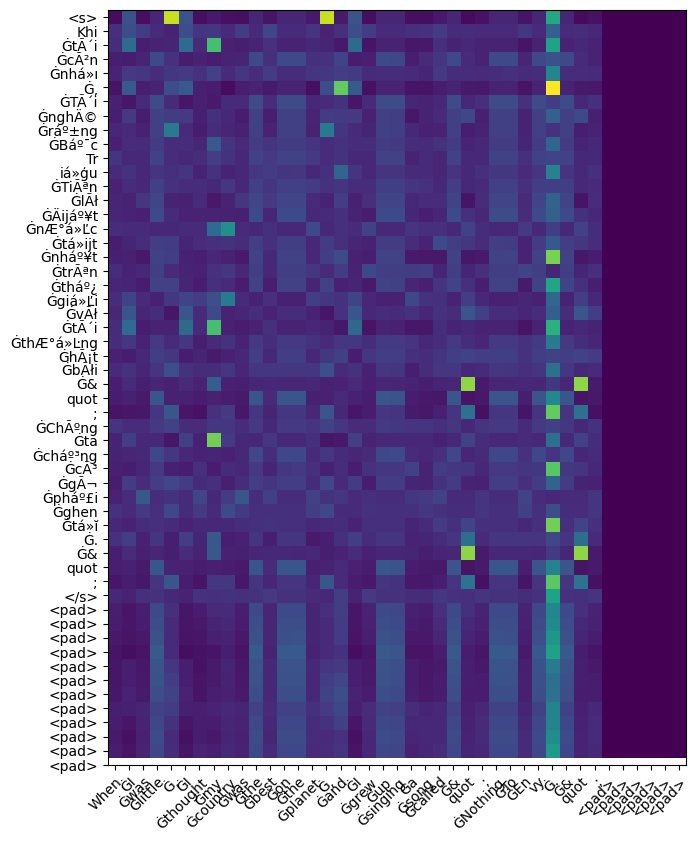

===== Input 1 =====


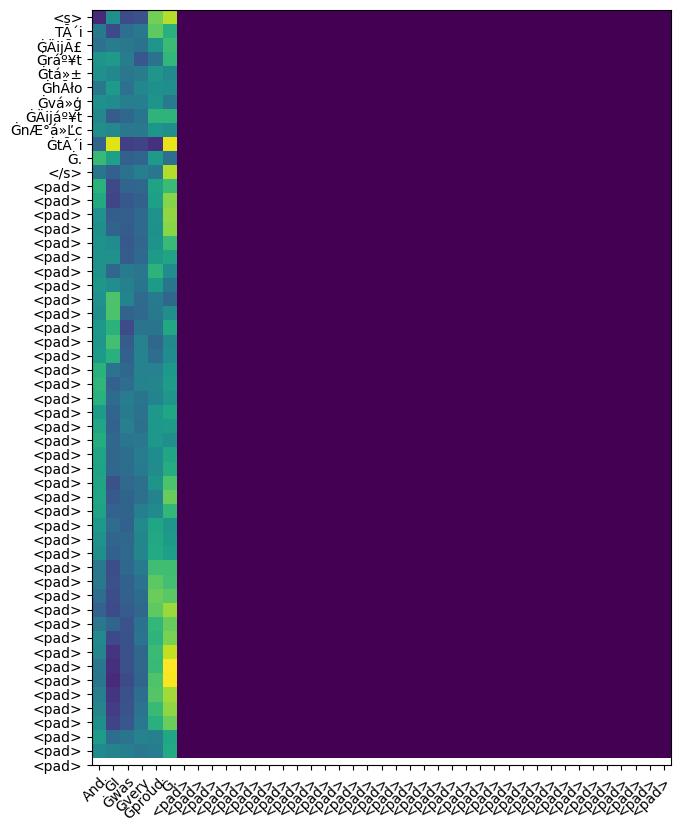

===== Input 2 =====


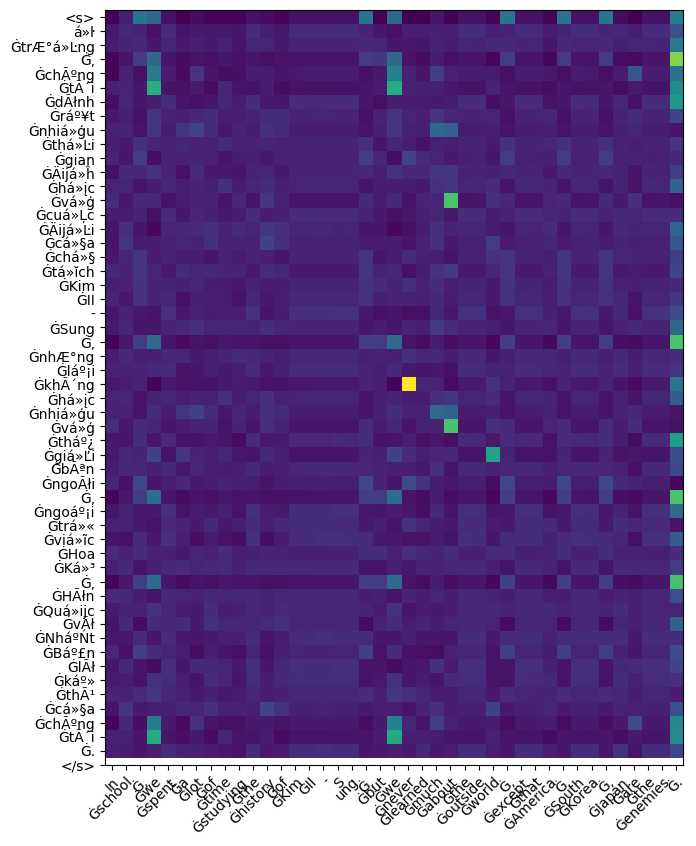

===== Input 3 =====


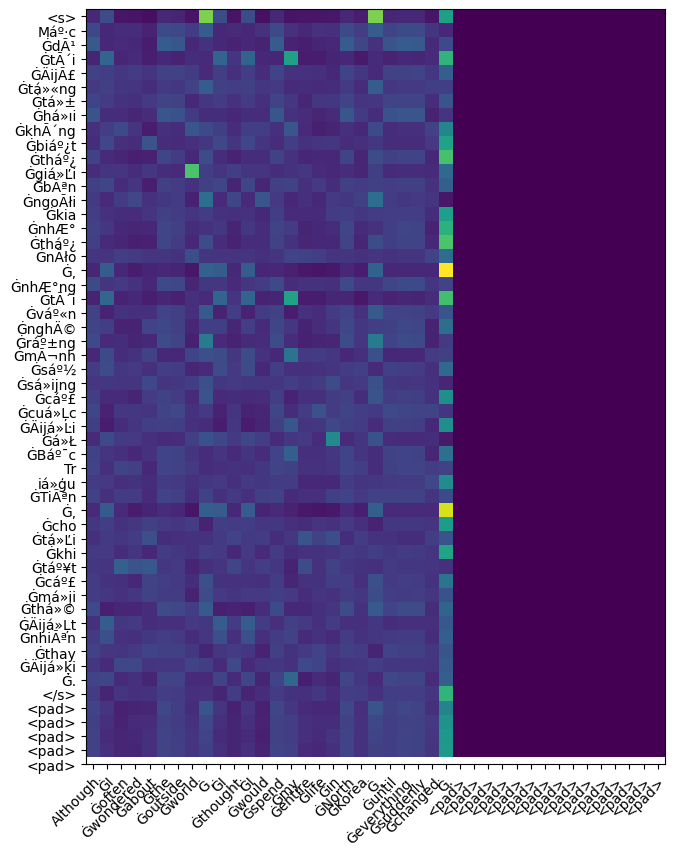

In [12]:
handle = model.decoder.layer_stack[0].enc_dec_attn.attention.register_forward_hook(hook)

for i, (src, trg) in enumerate(dl):
    src_tokens, trg_tokens, pred_tokens = make_prediction(i, src, trg)
    visualize_attn(attn, src_tokens, trg_tokens)
    break